In [23]:
# import
import numpy as np
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
plt.rc("figure", figsize=(12, 5), dpi=80)
pd.options.plotting.backend = "plotly"

# data
df = pd.read_pickle('data/df_daily.pkl').set_index('date')

store_list = df['store_id'].unique()


In [24]:
df_wide = df.pivot(columns='store_id', values='sales')
df_wide['day_of_week'] = df_wide.index.day_name()
df_wide['day'] = df_wide.index.day
df_wide['month'] = df_wide.index.month
df_wide['year'] = df_wide.index.year
df_wide.head()

store_id,307222,307244,307248,320264,328165,349920,349924,349952,349958,349962,...,480733,528854,536898,536902,566790,566792,day_of_week,day,month,year
date,,,,,,,,,,,,,,,,,,,,,
2017-08-07,1527650.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Monday,7,8,2017
2017-08-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday,8,8,2017
2017-08-09,26627420.0,NaN,NaN,NaN,8314900.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,9,8,2017
2017-08-10,10755720.0,2358650.0,NaN,NaN,7037470.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Thursday,10,8,2017
2017-08-11,10216950.0,389000.0,NaN,NaN,13699430.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Friday,11,8,2017


---
# Visual inspection
## Time plot

Insights from time plot:
* The dataset spans between August 2017 and January 2021, inclusively. Although more recent data is available, we decide to exclude them because since February 2021, Vietnam went through consecutive COVID lockdown periods during which, non-essential activities (including fashion retailing) had been largely inactive.
* There is no obvious upward or downward trend in the dataset.
* Weekly seasonality is very clear. Most peaks occur on Sundays. 
* Annual seasonality also exists:
    * The highest peaks take place at the end of November due to the major promotions of Black Friday every year.
    * The troughs occur on January/February due to Lunar New Year holidays. Total store sales remains low in the 2 next months.

In [25]:
# fig = df_wide.iloc[:, :4].plot()
fig = df_wide.plot()

# Lunar New Year
fig.add_vrect(x0='2018-02-15', x1='2018-02-21', line_width=0, fillcolor="black", opacity=0.3)
fig.add_vrect(x0='2018-02-21', x1='2018-04-21', line_width=0, fillcolor="black", opacity=0.1) # 2 following months
fig.add_vrect(x0='2019-02-04', x1='2019-02-10', line_width=0, fillcolor="black", opacity=0.3)
fig.add_vrect(x0='2019-02-10', x1='2019-04-10', line_width=0, fillcolor="black", opacity=0.1) # 2 following months
fig.add_vrect(x0='2020-01-24', x1='2020-01-30', line_width=0, fillcolor="black", opacity=0.3)
fig.add_vrect(x0='2020-01-30', x1='2020-03-31', line_width=0, fillcolor="black", opacity=0.1) # 2 following months

# COVID
fig.add_vrect(x0='2020-04-01', x1='2020-04-16', line_width=0, fillcolor="red", opacity=0.3) # whole country
fig.add_vrect(x0='2020-07-28', x1='2020-09-04', line_width=0, fillcolor="red", opacity=0.3) # Da Nang

fig.show()

ValueError: Plotly Express cannot process wide-form data with columns of different type.

## Data duration
* Different stores have different start days. To ensure sufficient data for modelling, we select only stores which:
    * are active until at least January 2021, and
    * have been active for more than 2 years
* As a result, 39 stores were selected. Among these, 26 stores have been in business for at least 3 years.

In [7]:
ls_first_day = []
for id in store_list: 
    ls_first_day.append(df_wide[id].first_valid_index())
df_dur = pd.DataFrame({'first': ls_first_day, 'last': '2021-01-31'}, index=store_list)


In [20]:
fig = px.timeline(df_dur, 
                  x_start="first", x_end="last", 
                  y=store_list.astype('str'),
                  labels={'y':'store_id'},
                  title='Store sales data availability'
                  )
# fig.update_yaxes()
fig.show()

In [4]:
data_len = df['store_id'].value_counts()

print('Number of selected stores:', len(data_len))
print('Number of stores at least 3 years old:', np.sum(data_len>(365*3+1)))


Number of selected stores: 39
Number of stores at least 3 years old: 26


## Seasonal plots - weekly

In general, sales is low at the beginning of each week and rises gradually towards weekend.

In [5]:
ts = df_wide.iloc[:,0]
fig = px.line(x=ts.index.day_name(), 
              y=ts,
              color=ts.index.isocalendar().week,
              color_discrete_sequence=px.colors.sequential.Emrld
              )

fig.update_layout(title_text='Weekly  seasonality plot',
                  legend_title_text='Week')
fig.update_xaxes(title='Day of week')
fig.update_yaxes(title='Sales')

fig.show()

In [78]:
# daily mean through the week
df_wide2 = df_wide.groupby('day_name').mean().iloc[:,:].sort_values(store_list[0])

fig = df_wide2.plot()

fig.update_layout(title_text='Weekly seasonality plot',
                  legend_title_text='Store ID')
fig.update_xaxes(title='Day of week')
fig.update_yaxes(title='Sales')

fig.show()

## Seasonal plots - annual
* before COVID (2017-2019), trend & seasonality are recognizable:
    * increasing trend except Feb & June
    * peaks in April, August, November
    * peak in January or February depending on Lunar New Year
* after COVID: 
    * 1st wave in April 2020
    * 2nd wave in August 2020
    * 3rd wave in February 2021
    * 4th wave in May-September 2021

few years & COVID cause difficulty in recognizing seasonalities

=> SHOULD WE INCLUDE ANNUAL SEASONALITY?


In [13]:
id = store_list[30]
df_wide_monthly = df_wide.loc['2018':'2020', :id].resample('M').sum()
ts_monthly = df_wide_monthly.iloc[:,0]
fig = px.line(x=ts_monthly.index.month_name(), 
              y=ts_monthly,
              color=ts_monthly.index.year,
              category_orders={'x':ts_monthly['2018'].index.month_name().values.tolist()},
              color_discrete_sequence=px.colors.sequential.Emrld
              )
fig.update_layout(title_text='Annual seasonality plot',
                  legend_title_text='Year')
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Sales')

fig.show()

## Histogram

In general, sales is low at the beginning of each week and rises gradually towards weekend.

In [7]:
px.histogram(ts)

## ACF/PACF plots


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/ap8/ap8venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



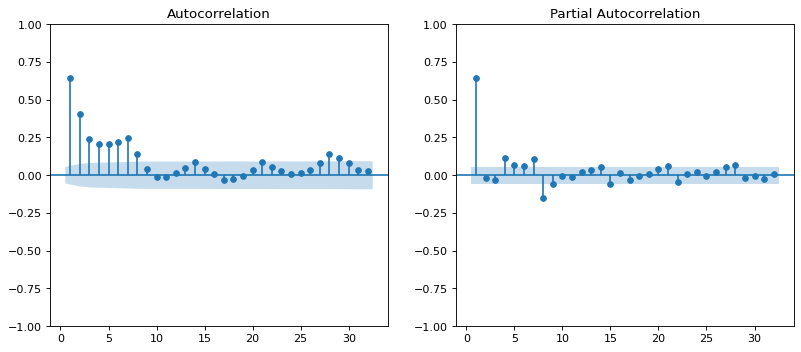

In [8]:
fig, ax = plt.subplots(1, 2)
plot_acf(ts, zero=False, ax=ax[0])
plot_pacf(ts, zero=False, ax=ax[1])
plt.show()

## STL


In [9]:
ts = df_wide.iloc[:, 0]
ts.plot()

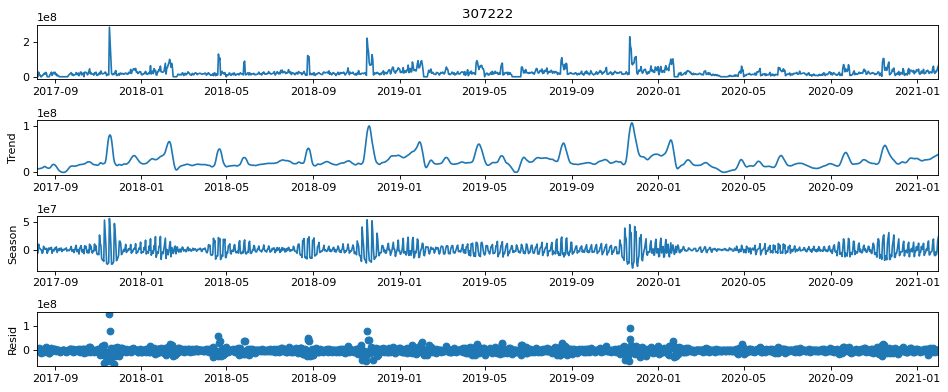

In [10]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=7)
res = stl.fit()
fig = res.plot()

---
# Descriptive statistics

In [1]:
ts.describe()

NameError: name 'ts' is not defined

## Stationarity

In [12]:
adfuller_res = adfuller(ts)
if adfuller_res[1] < 0.05: 
    print('Time series is stationary, i.e we reject the null hypothesis that there is a unit root because p-value < 0.05. \nNo need for differencing.')
else: 
    print('Time series is not stationary, i.e we cannot reject the null hypothesis that there is a unit root because p-value > 0.05.')


Time series is stationary, i.e we reject the null hypothesis that there is a unit root because p-value < 0.05. 
No need for differencing.
